In [3]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent          # eine Ebene über notebooks/
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, median_abs_deviation
from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq


PATH = "../data/Taxi_final_1M_clean.csv"
df = pd.read_csv(PATH)

print(80*"=")
print(f"Datensatz geladen: {df.shape[0]:,} Zeilen, {df.shape[1]} Spalten")
print(80*"-")
print("Erste Zeilen:", "\n", df.head(3))
print(80*"-")
print(df.describe())
print(80*"-")
print(df.info())
print(80*"=")

Datensatz geladen: 968,862 Zeilen, 17 Spalten
--------------------------------------------------------------------------------
Erste Zeilen: 
   tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2023-02-06 18:31:28   2023-02-06 18:41:28              1.0            2.8   
1  2023-01-24 12:53:51   2023-01-24 13:06:09              5.0            2.3   
2  2023-02-04 22:58:49   2023-02-04 23:03:11              2.0            1.1   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  tip_amount  \
0           162           113             1         11.4    2.5         2.0   
1           142            48             2         12.1    0.0         0.0   
2           107           107             1          5.8    3.5         1.2   

   tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  \
0           0.0                    1.0          19.9                   2.5   
1           0.0                    1.0          16.1           

## 1. Punktschätzung, Standardfehler und Konfidenzintervall

Die roten Linien markieren die 5% der zu erwartenden Fehlerfälle, bei einem 95%-Konfidenzintervall.

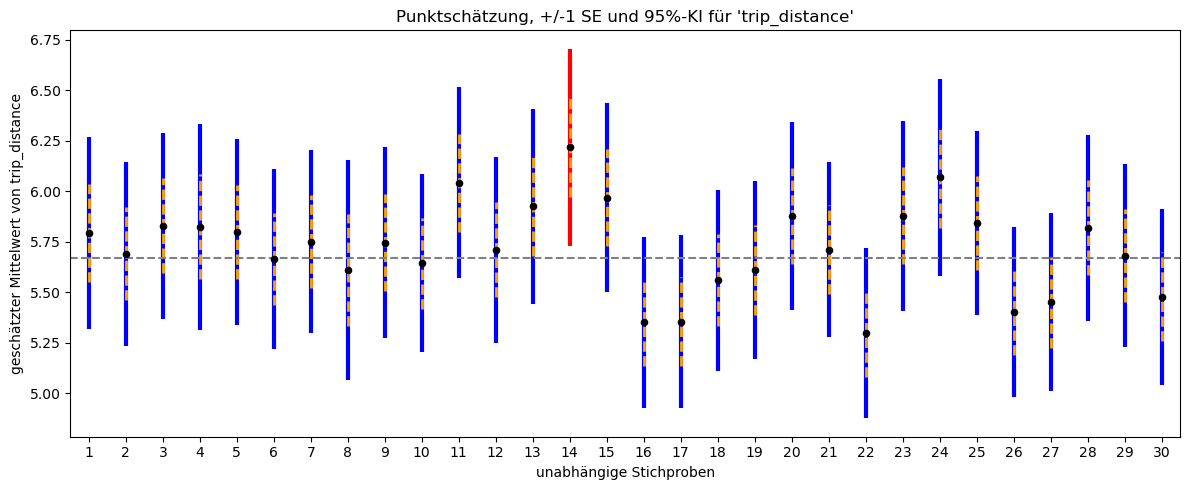

In [12]:
x = df["trip_distance"].to_numpy(dtype=float)
x = x[np.isfinite(x) & (x > 0)]
mu_true = x.mean()

# Parameter
S = 30          # Anzahl Stichproben
n = 1000        # Größe je Stichprobe
z = 1.96        # Etwa 95% der Daten liegen innerhalb von +/- 1.96 Standardabweichungen um den Mittelwert (-> laut Slide 95% Konfidenzintervall)

rng = np.random.default_rng(0)

means, standard_errors, lower_bounds, higher_bounds = [], [], [], []
for _ in range(S):
    stichprobe = rng.choice(x, size=n, replace=False)
    mean = stichprobe.mean()
    se = stichprobe.std(ddof=1) / np.sqrt(n)
    means.append(mean)
    standard_errors.append(se)
    lower_bounds.append(mean - z * se)
    higher_bounds.append(mean + z * se)

means = np.array(means)
standard_erros = np.array(standard_errors)
lower_bounds = np.array(lower_bounds)
higher_bounds = np.array(higher_bounds)

# Plot - optimized with AI
plt.figure(figsize=(12,5))
idx = np.arange(S)
for i in range(S):
    c = "blue" if (lower_bounds[i] <= mu_true <= higher_bounds[i]) else "red"
    plt.vlines(i, lower_bounds[i], higher_bounds[i], color=c, linewidth=3)           # 95%
    plt.vlines(i, means[i] - standard_erros[i], means[i] + standard_erros[i],        # +/- 1 SE
               color="orange", linestyles="--", linewidth=2)
plt.scatter(idx, means, color="black", s=20, zorder=3)            # Punkt-Schätzung
plt.hlines(mu_true, -0.5, S-0.5, colors="gray", linestyles="--")  # wahrer Mittelwert

plt.xticks(idx, idx+1); plt.xlim(-0.5, S-0.5)
plt.xlabel("unabhängige Stichproben")
plt.ylabel("geschätzter Mittelwert von trip_distance")
plt.title("Punktschätzung, +/-1 SE und 95%-KI für 'trip_distance'")
plt.tight_layout()
plt.show()

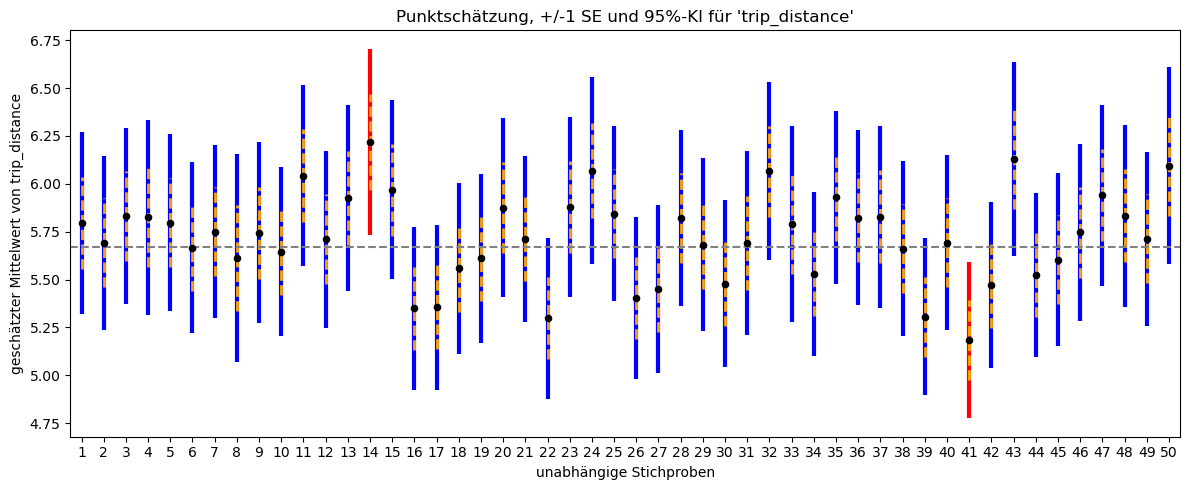

In [13]:
x = df["trip_distance"].to_numpy(dtype=float)
x = x[np.isfinite(x) & (x > 0)]
mu_true = x.mean()

# Parameter
S = 50          # Anzahl Stichproben
n = 1000        # Größe je Stichprobe
z = 1.96        # Etwa 95% der Daten liegen innerhalb von +/- 1.96 Standardabweichungen um den Mittelwert (-> laut Slide 95% Konfidenzintervall)

rng = np.random.default_rng(0)

means, standard_errors, lower_bounds, higher_bounds = [], [], [], []
for _ in range(S):
    stichprobe = rng.choice(x, size=n, replace=False)
    mean = stichprobe.mean()
    se = stichprobe.std(ddof=1) / np.sqrt(n)
    means.append(mean)
    standard_errors.append(se)
    lower_bounds.append(mean - z * se)
    higher_bounds.append(mean + z * se)

means = np.array(means)
standard_erros = np.array(standard_errors)
lower_bounds = np.array(lower_bounds)
higher_bounds = np.array(higher_bounds)

# Plot - optimized with AI
plt.figure(figsize=(12,5))
idx = np.arange(S)
for i in range(S):
    c = "blue" if (lower_bounds[i] <= mu_true <= higher_bounds[i]) else "red"
    plt.vlines(i, lower_bounds[i], higher_bounds[i], color=c, linewidth=3)           # 95%
    plt.vlines(i, means[i] - standard_erros[i], means[i] + standard_erros[i],        # +/- 1 SE
               color="orange", linestyles="--", linewidth=2)
plt.scatter(idx, means, color="black", s=20, zorder=3)            # Punkt-Schätzung
plt.hlines(mu_true, -0.5, S-0.5, colors="gray", linestyles="--")  # wahrer Mittelwert

plt.xticks(idx, idx+1); plt.xlim(-0.5, S-0.5)
plt.xlabel("unabhängige Stichproben")
plt.ylabel("geschätzter Mittelwert von trip_distance")
plt.title("Punktschätzung, +/-1 SE und 95%-KI für 'trip_distance'")
plt.tight_layout()
plt.show()

---

## 2. Bootstrap

Hier können wir den average Fahrweg (-> trip_distance) aller Taxis im Jahre 2023 betrachten. Dieser Mittelwert ist nur eine Stichprobenschätzung des korrekten Mittelwertes.
In dem Histogramm sieht man die empirische Verteilung der Mittelwerte. Die y-achse gibt dabei die Häufigkeit an, wie oft dieser Wert in 5000 Bootstrap-Stichproben vorkam.

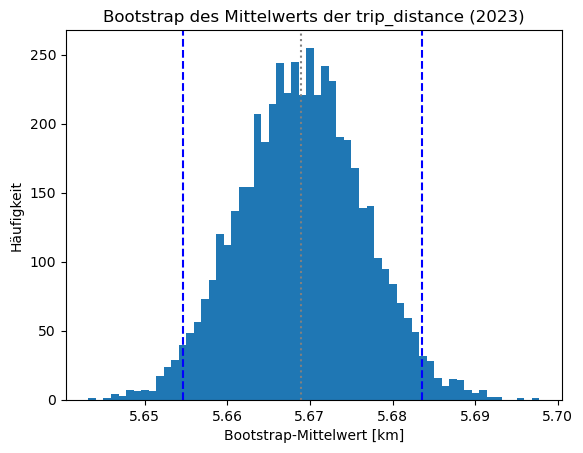

Mittelwert: 5.669 km
95% Konfidenzintervall: [5.65, 5.68] km


In [ ]:
df["tpep_pickup_datetime"] = df["tpep_pickup_datetime"].astype("datetime64[ns]")
df["tpep_dropoff_datetime"] = df["tpep_dropoff_datetime"].astype("datetime64[ns]")

x = df.loc[
    (df.tpep_pickup_datetime.dt.year == 2023), 
    "trip_distance"
].to_numpy(float)

x = x[np.isfinite(x) & (x > 0)]

B = 5000
rng = np.random.default_rng(0)
bootstrap_estimates = np.array([rng.choice(x, size=x.size, replace=True).mean() for _ in range(B)])

ci_lo, ci_hi = np.percentile(bootstrap_estimates, [2.5, 97.5])
mu_true = x.mean()

plt.hist(bootstrap_estimates, bins=60)
plt.axvline(ci_lo, ls="--", color="blue")
plt.axvline(ci_hi, ls="--", color="blue")
plt.axvline(mu_true, ls=":", color="gray")
plt.title("Bootstrap des Mittelwerts der trip_distance (2023)")
plt.xlabel("Bootstrap-Mittelwert in km")
plt.ylabel("Häufigkeit")
plt.show()

print(f"Mittelwert: {mu_true:.3f} km")
print(f"95% Konfidenzintervall: [{ci_lo:.2f}, {ci_hi:.2f}] km")

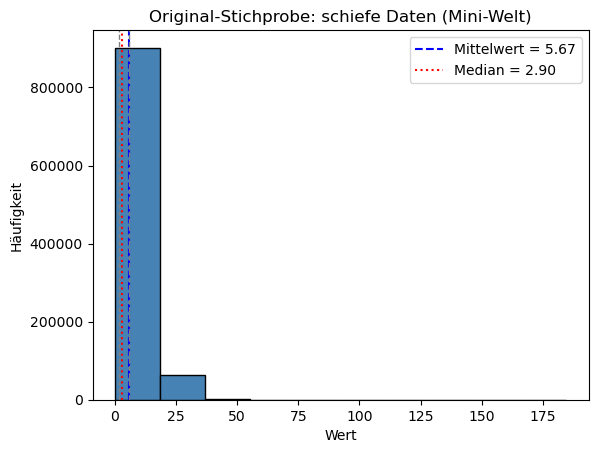

In [27]:
plt.hist(x, bins=10, color="steelblue", edgecolor="black")
plt.axvline(x.mean(), color="blue", ls="--", label=f"Mittelwert = {x.mean():.2f}")
plt.axvline(np.median(x), color="red", ls=":", label=f"Median = {np.median(x):.2f}")
plt.axvline(np.percentile(x, 25), color="gray", ls="--", lw=1)
plt.axvline(np.percentile(x, 75), color="gray", ls="--", lw=1)
plt.title("Original-Stichprobe: schiefe Daten (Mini-Welt)")
plt.xlabel("Wert"); plt.ylabel("Häufigkeit")
plt.legend()
plt.show()

***Vergleich Reale Stichprobe & Bootstrap-Verteilung***

**Originale Stichprobe:**
 - sehr rechtsschief
 - Die rote gestrichelte Linie markiert den Stichprobenmittelwert (Punktschätzung für den tatsächlichen Durchschnitt aller Fahrten im Jahre 2023)

**Bootstrap Verteilung der Mittelwerte**
 - Hier können wir die Verteilung der Mittelwerte sehen, welche wir durch 5000 Bootstrap-Stichproben erhalten haben. Die Stichproben sind mit Zurücklegen aus den Originaldaten implementiert. 
 - Diese Verteilung ist fast symmetrisch und schmal $\rightarrow$ der Mittelwert is also ein stabiler Schätzer, da er nicht extrem zwischen Stichproben schwankt.
 - Die schwarz gestichelten Linien zeigen das 95% Konfidenzintervall.

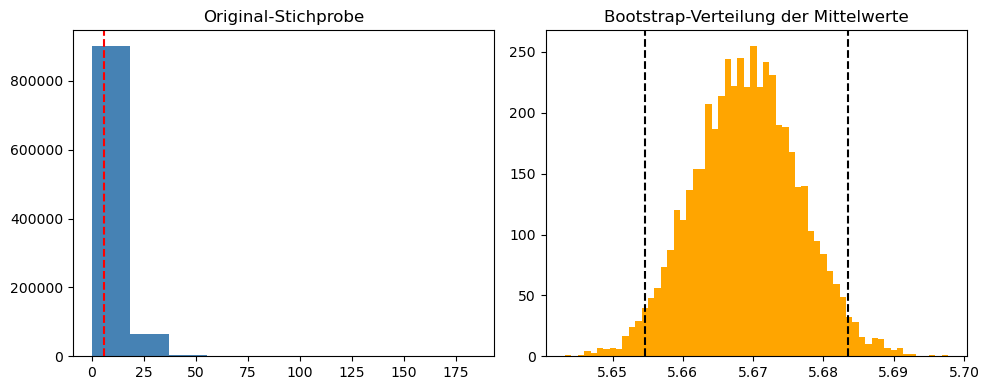

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(x, bins=10, color="steelblue")
ax[0].axvline(x.mean(), color="red", ls="--", label="Stichprobenmittel")
ax[0].set_title("Original-Stichprobe")

ax[1].hist(bootstrap_estimates, bins=60, color="orange")
ax[1].axvline(np.percentile(bootstrap_estimates, 2.5), color="black", ls="--")
ax[1].axvline(np.percentile(bootstrap_estimates, 97.5), color="black", ls="--")
ax[1].set_title("Bootstrap-Verteilung der Mittelwerte")
plt.tight_layout(); plt.show()

## 2. Primer
